The use of artificial intelligence in analyzing medical imagery is a problem AI researchers are constantly trying to solve. This is the case not only because making use of such tools would speed up critical procedures like cancer identification, but also because it frees up our most capable professionals to focus their knowledge and expertise on the critical problems that may result in future breakthroughs. It is for this reason that I believe it is critically important that we continue to tackle this problem with more robust models and further prove that the technology is worth implementing on mass scales in highly professional fields such as this.

In this project we will use machine learning techniques to analyze various image patches of breast cancer in an attempt to the four histological distinct types of **benign breast** tumors: 
- adenosis (A)
- fibroadenoma (F)
- phyllodes tumor (PT)
- tubular adenona (TA)

and four types of **malignant tumors** (breast cancer):
- carcinoma (DC)
- lobular carcinoma (LC)
- mucinous carcinoma (MC)
- papillary carcinoma (PC)

With the goal of We will begin with some initial analysis of the dataset to better understand its composition through shape, feature types, repeating data, etc. We will then proceed to clean the data based on our analysis in order to make better use of it. From there we will  work to develop and refine models to achieve our primary goal of identifying the images and finally we will analyze our results in order to develop future avenues of investigation.

# Import Packages

In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation

2025-12-09 21:57:54.985444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765317475.158059      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765317475.210963      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Import Data

In [2]:
folds = pd.read_csv("/kaggle/input/breakhis/Folds.csv")
base_path = "/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast"
images_list = list(pathlib.Path(base_path).rglob("*.png"))

rows = []
for p in images_list:
    parts = p.parts
    cancer_activity = parts[-6]
    cancer_classes = parts[-4]
    patient_id = parts[-3]
    magnification = parts[-2]
    rows.append({"path": str(p), "cancer_activity": cancer_activity, "cancer_classes": cancer_classes, "patient_id": patient_id, "magnification": magnification})

image_data = pd.DataFrame(rows)
image_data.sample(5)

,path,cancer_activity,cancer_classes,patient_id,magnification
3176,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,malignant,mucinous_carcinoma,SOB_M_MC_14-13418DE,200X
1628,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,fibroadenoma,SOB_B_F_14-23060CD,40X
5867,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,malignant,ductal_carcinoma,SOB_M_DC_14-9461,200X
4172,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,malignant,ductal_carcinoma,SOB_M_DC_14-16601,400X
1678,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,fibroadenoma,SOB_B_F_14-21998EF,400X


# EDA
We will begin with some initial analysis of the datasets to better understand its meta composition through shape, feature types, repeating data, missing values, etc. As we are dealing with image data we will also check the shape of the image. This will give us a much better idea of the data we are working with as well as help us identify if any cleaning will be required. It is quite important that we do an initial check on what data exists however as our dataset is making several different claims about how much data it has available such as there being "9,109 microscopic images of breast tumor tissue collected", "39,545 images available", and "2,480 benign and 5,429 malignant samples (700X460 pixels, 3-channel RGB, 8-bit depth in each channel, PNG format)".
## Dataset Overview

In [3]:
def print_unique_data(folds):
    for col in folds.columns.tolist():
        if col == 'filename':
            continue
        uniques = folds[col].unique()
        print(f"Unique {col} Data: {', '.join(map(str, uniques))}")
    print('\n')

def print_initial_data():
    print("Meta Data")
    print("Data Shape:", folds.shape, '\n')
    print("Columns:", folds.columns.tolist(), '\n')
    print("Example Filename:", folds['filename'][0], '\n')
    print_unique_data(folds)
    print(f"Number of duplicate data points: {folds.duplicated().sum()}")
    print(f"Number of unique image references: {len(folds['filename'].unique())}")
    print(f"Number of duplicate image references: {folds['filename'].duplicated().sum()}\n")
    print("Data Info:", folds.info(), '\n')
    print(folds.sample(5))

In [4]:
print_initial_data()

Meta Data
Data Shape: (39545, 4) 

Columns: ['fold', 'mag', 'grp', 'filename'] 

Example Filename: BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png 

Unique fold Data: 1, 2, 3, 4, 5
Unique mag Data: 100, 200, 40, 400
Unique grp Data: train, test


Number of duplicate data points: 0
Number of unique image references: 7909
Number of duplicate image references: 31636

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39545 entries, 0 to 39544
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   fold      39545 non-null  int64 
 1   mag       39545 non-null  int64 
 2   grp       39545 non-null  object
 3   filename  39545 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.2+ MB
Data Info: None 

       fold  mag    grp                                           filename
33212     5  100  train  BreaKHis_v1/histology_slides/breast/malignant/...
36569     5  400

In [5]:
print("Total number of PNG images:", len(image_data))

Total number of PNG images: 7909


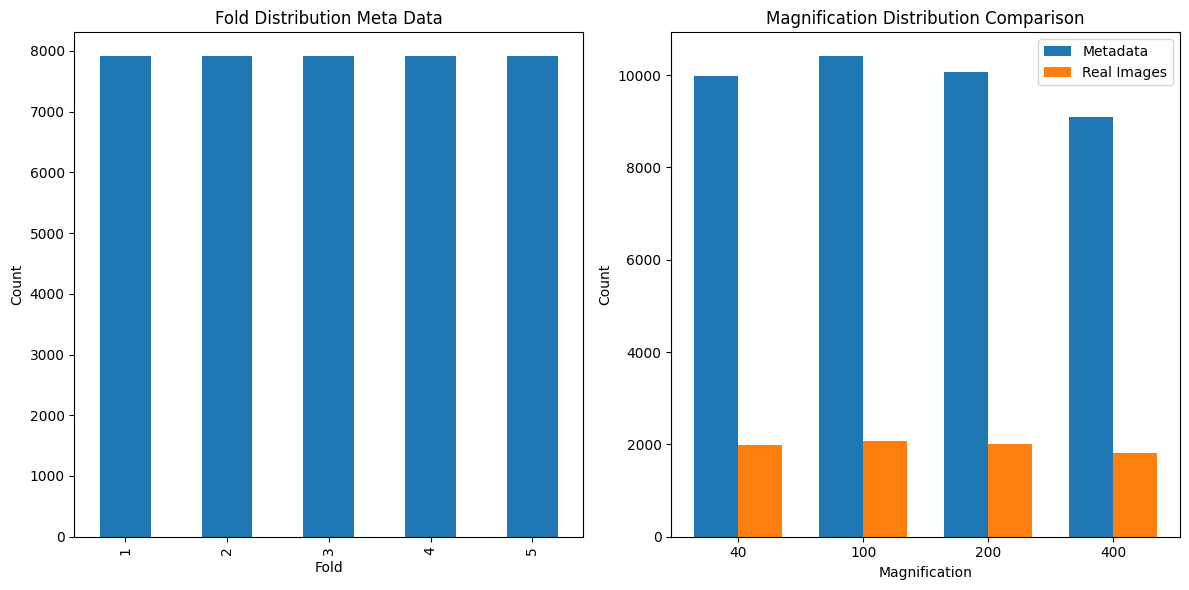

In [6]:
meta_counts = folds['mag'].value_counts().sort_index()
real_counts = image_data['magnification'].astype(str).str.replace("X","").astype(int).value_counts().sort_index()
magnifications = sorted(set(meta_counts.index).union(real_counts.index))
x = np.arange(len(magnifications))
width = 0.35

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
folds['fold'].value_counts().plot(kind='bar')
plt.title('Fold Distribution Meta Data')
plt.xlabel('Fold')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.bar(x - width/2, [meta_counts.get(m, 0) for m in magnifications], width, label='Metadata')
plt.bar(x + width/2, [real_counts.get(m, 0) for m in magnifications], width, label='Real Images')

plt.xticks(x, magnifications)
plt.title("Magnification Distribution Comparison")
plt.xlabel("Magnification")
plt.ylabel("Count")
plt.legend()

plt.tight_layout()
plt.show()

cancer_activity
malignant    5429
benign       2480
Name: count, dtype: int64
cancer_classes
ductal_carcinoma       3451
fibroadenoma           1014
mucinous_carcinoma      792
lobular_carcinoma       626
tubular_adenoma         569
papillary_carcinoma     560
phyllodes_tumor         453
adenosis                444
Name: count, dtype: int64


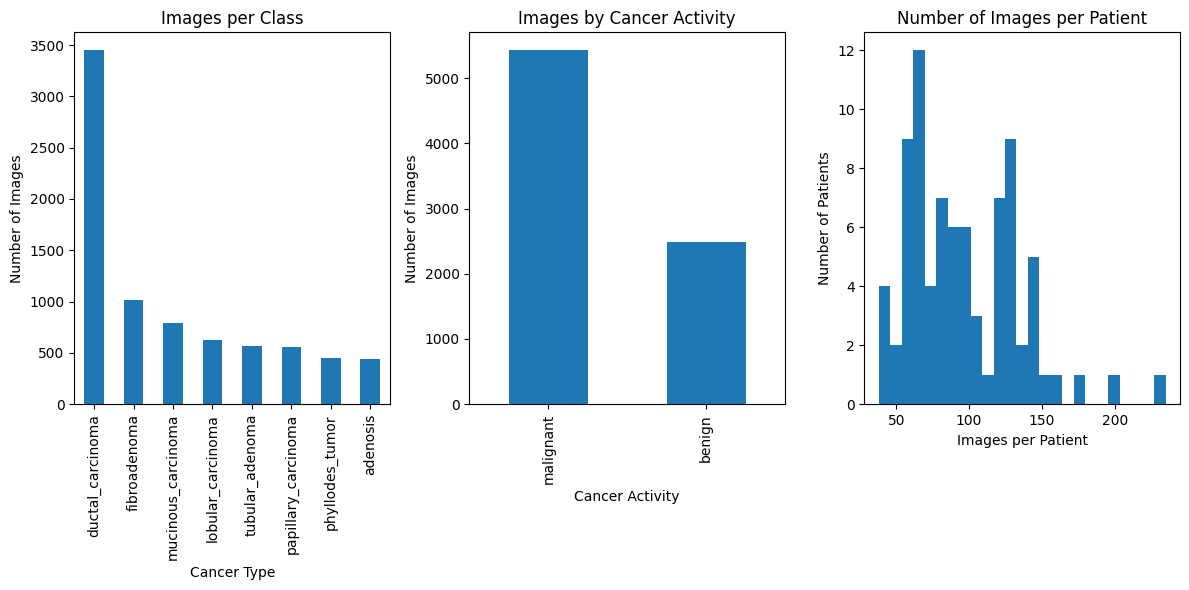

In [7]:
print(image_data['cancer_activity'].value_counts())
print(image_data['cancer_classes'].value_counts())
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
image_data['cancer_classes'].value_counts().plot(kind='bar')
plt.title('Images per Class')
plt.xlabel('Cancer Type')
plt.ylabel('Number of Images')

plt.subplot(1, 3, 2)
image_data['cancer_activity'].value_counts().plot(kind='bar')
plt.title('Images by Cancer Activity')
plt.xlabel('Cancer Activity')
plt.ylabel('Number of Images')

plt.subplot(1, 3, 3)
plt.hist(image_data.groupby('patient_id').size(), bins=25)
plt.title("Number of Images per Patient")
plt.xlabel("Images per Patient")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.show()

path
(700, 460)    7835
(700, 456)      74
Name: count, dtype: int64
cancer_classes
papillary_carcinoma    74
Name: count, dtype: int64


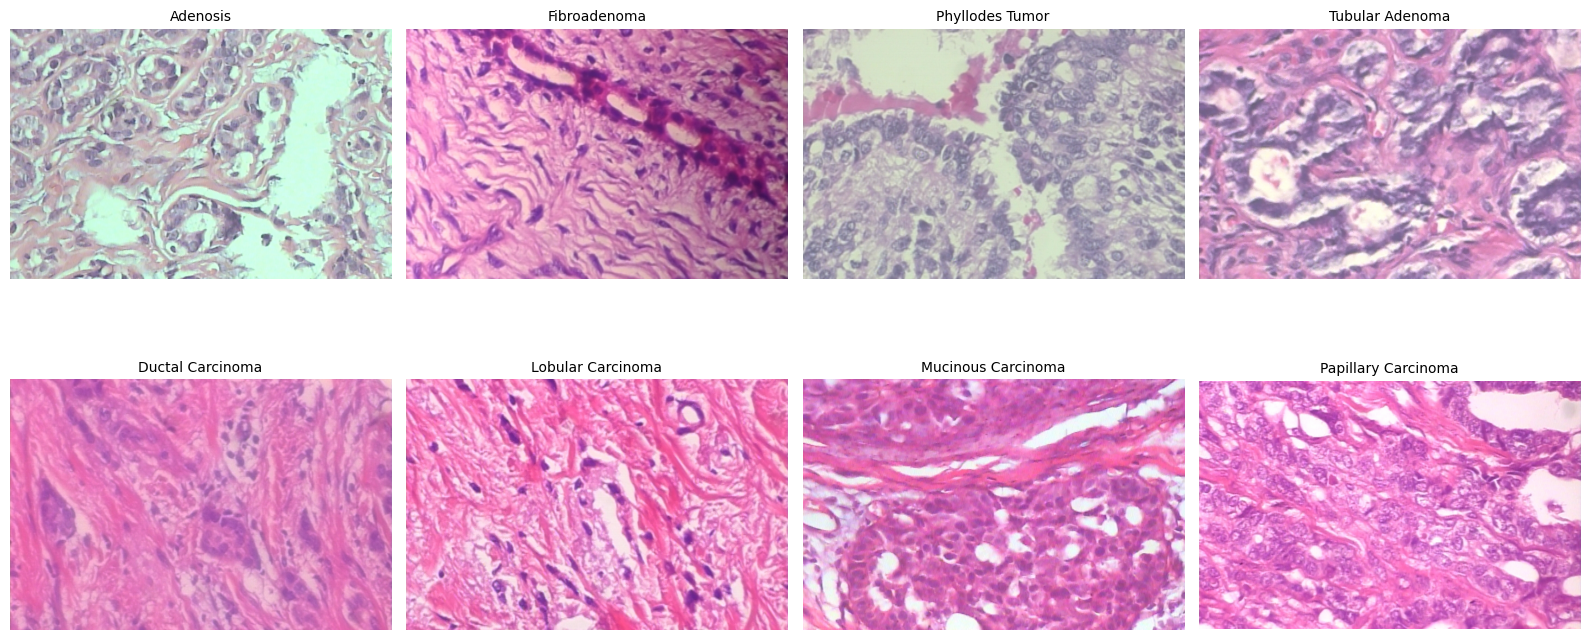

In [8]:
cancer_classes = ['adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma', 'ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma']
shapes = image_data['path'].apply(lambda p: Image.open(p).size)
shape_counts = shapes.value_counts()
print(shape_counts[:10])

small_images = image_data[shapes == (700, 456)]
small_images_counts = small_images['cancer_classes'].value_counts()
print(small_images_counts)


fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, cls in enumerate(cancer_classes):
    cls_image = image_data[image_data['cancer_classes'] == cls]
    if len(cls_image) == 0:
        continue
    
    img = Image.open(cls_image.iloc[0]['path'])
    
    ax = axes[i//4, i%4]
    ax.imshow(img)
    ax.set_title(cls.replace("_", " ").title(), fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()


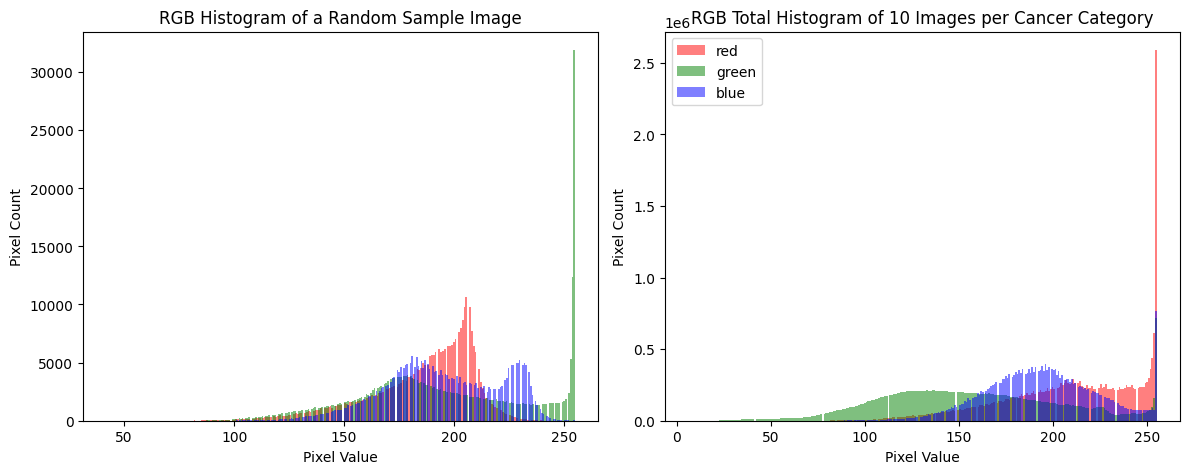

In [9]:
def analyze_image_colors():
    sampled_images = []
    for cls in image_data['cancer_classes'].unique():
        correct_images = image_data[(image_data['cancer_classes'] == cls) & (image_data['path'].apply(lambda p: Image.open(p).size == (700, 460)))]['path'].head(10).tolist()
        sampled_images.extend(correct_images)
        
    images_np = np.array([np.array(Image.open(p)) for p in sampled_images])
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sample_img = images_np[0]
    for i, color in enumerate(['red', 'green', 'blue']):
        plt.hist(sample_img[:, :, i].ravel(), bins=256, alpha=0.5, color=color)
    plt.title('RGB Histogram of a Random Sample Image')
    plt.xlabel('Pixel Value')
    plt.ylabel('Pixel Count')
    
    plt.subplot(1, 2, 2)
    for i, color in enumerate(['red', 'green', 'blue']):
        plt.hist(images_np[:, :, :, i].ravel(), bins=256, alpha=0.5, color=color, label=color)
    plt.title('RGB Total Histogram of 10 Images per Cancer Category')
    plt.xlabel("Pixel Value")
    plt.ylabel("Pixel Count")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

analyze_image_colors()

## Evaluating Data
It is quite apperant that our data is split up into several different folders by a number of factors such as benign or malignant, specific cancer type, and even the zoom magnitude used when taking the photo. It is also relatively clear that the Folds.csv file is a metadata document likely made to make analyzing and tracking the actual image data easier. It makes the following claims about our data:
- **Total Records:** 39,545 image metadata entries -> **7,909 image actually exist**
- **Features:** 4 metadata columns (two integer and two string)
    - Filename: String data pointing to image location in directory
    - GRP: String data indicating if the image is to be test or train data
    - MAG: Integer data showing the magnitude at which the image was shot
    - Fold: Unknown Column

From looking at the structure of the data with the existance of the fold and grp columns we can infer that the dataset creator had a model and use case for the data in mind and the **Fold Distribution Meta Data** table shows further evidence for this. Unfortunately without a concrete description of columns like fold it is better to simply get rid of these data points and start from scratch. We can already see how making use of it might confuse us and our models as it vastly inflates the data by referencing the same image multiple times per fold and this difference is best displayed in the **Magnification Distribution Comparision** chart. When we compare this with our direct analysis of the image files we can see clearly that we have exactly 7,909 unique png files available to us. It is for this reason that I will be ignoring the meta data and focusing solely on the images and label information.

### Data Quality
Overall our data appears moderately healthy as there are some moderate and minor challanges, but nothing that cannot be cleaned or managed. We have already seen that no images are missing and that they are all appropriately referenced outside of Folds.csv. We will have to resize or remove the 74 images that are sized 700 by 456 instead of the expected 700 by 460 that the rest of our data follows. We can see that all 74 instances of the odd sizes come from the **papillary carcinoma** category which is a **malignant** cancer. This is relavent to us because there are two more distinct issues in our distribution of data relating to our data distributions. As we can see the malignant data is far more prevalent than the benign data though it is important to note that this is not always a bad thing. It may be the case that this is an inherant truth to cancer that malignant cancers are more likely than benign ones and in that case it could be helpful to have a model that defaults to malignant when unsure. However, it may also be the case that this is a data collection issue and more data exists on malignant cancer simply because that is when it becomes most visible. This would be the point at which we invite a domain expert to share their thoughts to improve our model but since we do not have access to any such expert it would be safter to assume a data collection issue and even out the data. This is further complicated by the fact that a significant portion of the difference between malignant and benign cancer is in the **ductal carcinoma** column.

### Data Plan
We will proceed with the following cleanings :
1. Resize all images from (700, 456) and (700, 460) to (256, 256)
2. Normalize image color from (0, 255) to (0, 1)
3. Remove the data randomly from ductal carcinoma until it is equal to fibroadenoma

for the following reasons:
1. While the optimal choice would be to make the minor change of bringing (700, 456) to (700, 460), we must take into account our time and device capabaility and recognize we cannot handle images of such high quality in large amounts. We may revisit this choice if the results are particularly bad.
2. This is an important step that often improves model accuracy by scaling them to a smoother data range like 0 to 1.
3. To remain safe without domain knowledge it is simply best to even out extreme outliers in data. Doing this should greatly minimize the outlier of malignant data and ductal carcinoma data. It should be noted that we considered randomly removing data from the malignant category or using a weighted random removal process to retain some features of the data, but concluded that the focus would be on the image data itself.

### Thoughts on Data
It is interesting to see the distribution of data collected per individual. While there are some clear outliers that provided over 200 data points, the distribution generally follows the expected normal distribution even if slighly skewed. It is also interesting to see the pixel color distribution because it is somewhat visually apperant that certain cancer categories are more one color than another. This is apperant in the 10 image distribution graph where there is a distinct split in red, green and blue. I would be curious to see if the model learns this and if it is a photo defect rather than anything of significance.

## Data Cleaning

cancer_activity
malignant    2992
benign       2480
Name: count, dtype: int64
cancer_classes
fibroadenoma           1014
ductal_carcinoma       1014
mucinous_carcinoma      792
lobular_carcinoma       626
tubular_adenoma         569
papillary_carcinoma     560
phyllodes_tumor         453
adenosis                444
Name: count, dtype: int64


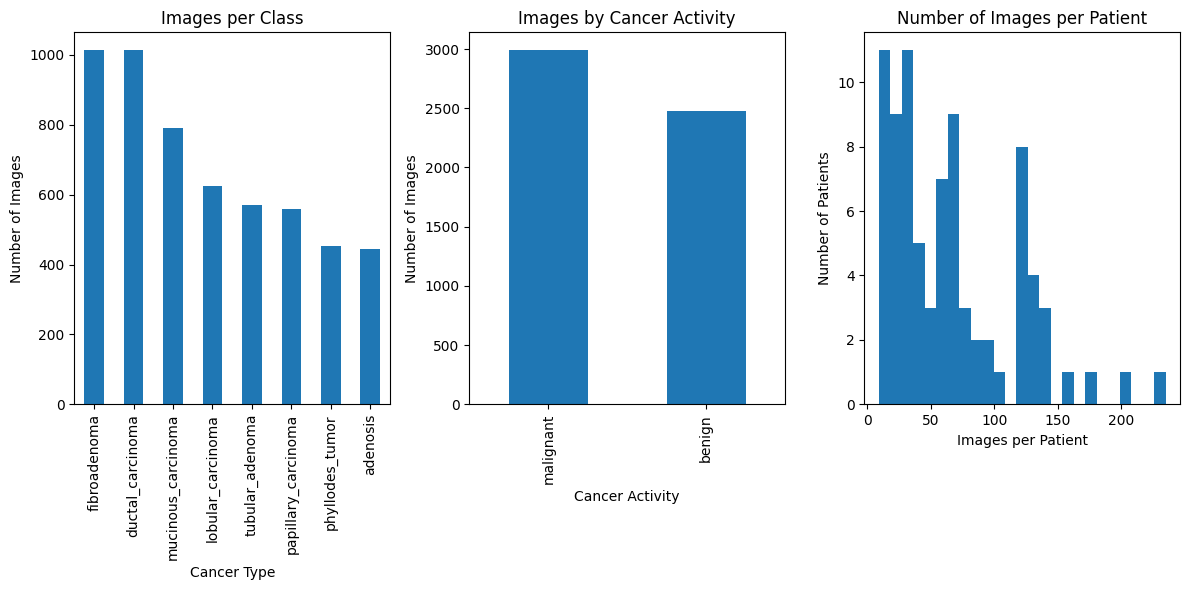

In [10]:
# https://www.tensorflow.org/tutorials/load_data/images
# https://www.tensorflow.org/guide/data
# https://cs230.stanford.edu/blog/datapipeline/

def remove_excess_data(data):
    ductal_carcinoma_indices = data[data['cancer_classes'] == "ductal_carcinoma"].index
    num_to_remove = min(2437, len(ductal_carcinoma_indices))
    return data.drop(np.random.choice(ductal_carcinoma_indices, size=num_to_remove, replace=False)).reset_index(drop=True)

def load_and_preprocess_image(img_path, target_size=(256, 256)):
    img = Image.open(img_path)
    img = img.resize(target_size)
    return np.array(img) / 255.0

def load_images(dataframe, label = 'binary_label', target_size=(256, 256)):
    images = []
    labels = []
    
    for idx, row in dataframe.iterrows():
        img = load_and_preprocess_image(row['path'], target_size)
        images.append(img)
        labels.append(row[label])
    
    return np.array(images), np.array(labels)

def parse(filename, label, target_size = (256, 256)):
    image = tf.image.decode_jpeg(tf.io.read_file(filename), channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_size)
    return image, label

clean_image_data = remove_excess_data(image_data)
clean_image_data['binary_label'] = clean_image_data['cancer_activity'].map({'benign': 0, 'malignant': 1})
label_mapping = {cls: idx for idx, cls in enumerate(cancer_classes)}
clean_image_data['multi_label'] = clean_image_data['cancer_classes'].map(label_mapping)

print(clean_image_data['cancer_activity'].value_counts())
print(clean_image_data['cancer_classes'].value_counts())
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
clean_image_data['cancer_classes'].value_counts().plot(kind='bar')
plt.title('Images per Class')
plt.xlabel('Cancer Type')
plt.ylabel('Number of Images')

plt.subplot(1, 3, 2)
clean_image_data['cancer_activity'].value_counts().plot(kind='bar')
plt.title('Images by Cancer Activity')
plt.xlabel('Cancer Activity')
plt.ylabel('Number of Images')

plt.subplot(1, 3, 3)
plt.hist(clean_image_data.groupby('patient_id').size(), bins=25)
plt.title("Number of Images per Patient")
plt.xlabel("Images per Patient")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.show()

train_sample_binary, validate_sample_binary = train_test_split(clean_image_data, test_size=0.2, stratify=clean_image_data['binary_label'], random_state=42)
train_sample_multi, validate_sample_multi = train_test_split(clean_image_data, test_size=0.2, stratify=clean_image_data['multi_label'], random_state=42)

In [11]:
dataset_binary_train = tf.data.Dataset.from_tensor_slices((train_sample_binary['path'].values, train_sample_binary['binary_label'].values))
dataset_binary_train = dataset_binary_train.map(parse).batch(16)
dataset_binary_validate = tf.data.Dataset.from_tensor_slices((validate_sample_binary['path'].values, validate_sample_binary['binary_label'].values))
dataset_binary_validate = dataset_binary_validate.map(parse).batch(16)

dataset_multi_train = tf.data.Dataset.from_tensor_slices((train_sample_multi['path'].values, train_sample_multi['multi_label'].values))
dataset_multi_train = dataset_multi_train.map(parse).batch(16)
dataset_multi_validate = tf.data.Dataset.from_tensor_slices((validate_sample_multi['path'].values, validate_sample_multi['multi_label'].values))
dataset_multi_validate = dataset_multi_validate.map(parse).batch(16)

I0000 00:00:1765317631.919220      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765317631.919854      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Model
We will be training multiple models to tackle this problem. In order to get a baseline model for the binary classification of our data, we will be using a very simple Convolutional Neural Network. We will then proceed to create a Refined Binary Classification Convolutional Neural Network by managing and manipulating the hyperparameters available. The goal in doing so is to identify if there are any parameters or set of parameters that provide notable boosts to model performance while also moving towards a CNN architecture that is hopefully more effective than our mase model. From here we will attempt to create a Multi-label Image Classification model based on our refined CNN and finally we will once again test to see if there are any hyperparameter refinements that can be made to improve the model.
## Model Chosen
### CNN
A Convolutional Neural Networks is a neural network approach that primarily makes use of convolutions almost always in the form of a convolution hidden layer. These layers are significant because unlike fully connected layers, convoluted layers do not connect every input data point to every input neuron and instead apply small limited filters that run across the input. Not only does this limited connectivity vastly decrease the number of required calculations, the small filters are forced to learn small but significant aspects of the input they can see. This results in filters that learn to detect local features like edges and textures in the case of images. This ability to learn localy significant features is the reason I and many others have picked the CNN as my primary model for image classification problems like these.
## Models Not Chosen
### RNN
We had briefly considered making use of a Recurrent Neural Network (RNN) to approach this project. After reading the research paper "CNN-RNN: A Unified Framework for Multi-label Image Classification" and learning more about the Recurant Attention Model (RAM), it seemed like approaching image classification with an RNN was feasible. It is first important to note that an RNN is not typically used for image classification because they are most often used with sequential data. Data such as audio and video that pass in sequence over time or text which is a sequence of letters. This does not lend itself well to the singular static image. RNN's also struggle when attempting to use the pixel data in sequence like we do with text as there is usually not enough information in a single pixel or a series of them to learn information that can be well generalized.
### RAM
Recurrent Attention Model's were developed to resolve this issue by treating images like smaller snapshot images that are moved in sequence by the attention architecture. In doing so we can overcome a major issue restricting RNN's from solving more image classification tasks. Unfortunately more research showed that a RAM would likely not have performed well or better than a CNN with the dataset we have chosen. For one, it is possible for our RAM to simply miss some critical indicater because it did not draw attention. We must keep in mind that medical professionals typically have more data than pictures and a vast body of knowledge to draw on when deciding what does and does not require attention. Implementing such a thing for our model would be impossible.
https://arxiv.org/pdf/1604.04573
## Simple CNN


In [12]:
class SimpleCNN:
    def __init__(self, input_shape=(256,256,3)):
        self.input_shape = input_shape
        self.model = self.build_model()
        self.history = None
    
    def build_model(self):
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape = self.input_shape))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    def show_model(self):
        self.model.summary()
    
    def train(self, train_data, validate_data, epochs = 5):
        self.history = self.model.fit(train_data, epochs=epochs, validation_data=validate_data)
        return self.history
    
    def display_results(self, X_validate, y_validate):
        fig, axs = plt.subplots(1, 2, figsize=(14,5))

        axs[0].plot(self.history.history['accuracy'], label='accuracy')
        axs[0].plot(self.history.history['val_accuracy'], label='val_accuracy')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Accuracy')
        axs[0].set_ylim([0, 1])
        axs[0].legend()
        axs[0].set_title('Accuracy over Epochs')
        
        axs[1].plot(self.history.history['loss'], label='train_loss')
        axs[1].plot(self.history.history['val_loss'], label='val_loss')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss')
        axs[1].legend()
        axs[1].set_title('Loss over Epochs')
    
        plt.show()

        y_pred = (self.model.predict(X_validate) > 0.5).astype(int)
        cm = confusion_matrix(y_validate, y_pred, labels=[0, 1])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(xticks_rotation=45)

## Refined CNN

In [13]:
class RefinedCNN:
    def __init__(self, input_shape=(256,256,3)):
        self.input_shape = input_shape
        self.model = self.build_model()
        self.history = None
    
    def build_model(self):
        model = Sequential()
        model.add(Conv2D(32, (3, 3), input_shape = self.input_shape))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv2D(32, (3, 3), input_shape = self.input_shape))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D((2, 2)))
        
        model.add(Conv2D(64, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D((2, 2)))
        
        model.add(Conv2D(128, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv2D(128, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D((2, 2)))
        
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
        opt = AdamW(learning_rate=1e-4, weight_decay=1e-5)
        model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    def show_model(self):
        self.model.summary()
    
    def train(self, train_data, validate_data, epochs = 5):
        self.history = self.model.fit(train_data, epochs=epochs, validation_data=validate_data)
        return self.history
    
    def display_results(self, X_validate, y_validate):
        fig, axs = plt.subplots(1, 2, figsize=(14,5))

        axs[0].plot(self.history.history['accuracy'], label='accuracy')
        axs[0].plot(self.history.history['val_accuracy'], label='val_accuracy')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Accuracy')
        axs[0].set_ylim([0, 1])
        axs[0].legend()
        axs[0].set_title('Accuracy over Epochs')
        
        axs[1].plot(self.history.history['loss'], label='train_loss')
        axs[1].plot(self.history.history['val_loss'], label='val_loss')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss')
        axs[1].legend()
        axs[1].set_title('Loss over Epochs')
    
        plt.show()

        y_pred = (self.model.predict(X_validate) > 0.5).astype(int)
        cm = confusion_matrix(y_validate, y_pred, labels=[0, 1])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(xticks_rotation=45)

## SimpleCNN - Multi

In [19]:
class SimpleCNNMulti:
    def __init__(self, input_shape=(256,256,3)):
        self.input_shape = input_shape
        self.model = self.build_model()
        self.history = None
    
    def build_model(self):
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape = self.input_shape))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(256, activation='softmax'))
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model
    
    def show_model(self):
        self.model.summary()
    
    def train(self, train_data, validate_data, epochs = 5):
        self.history = self.model.fit(train_data, epochs=epochs, validation_data=validate_data)
        return self.history
    
    def display_results(self, X_validate, y_validate):
        fig, axs = plt.subplots(1, 2, figsize=(14,5))

        axs[0].plot(self.history.history['accuracy'], label='accuracy')
        axs[0].plot(self.history.history['val_accuracy'], label='val_accuracy')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Accuracy')
        axs[0].set_ylim([0, 1])
        axs[0].legend()
        axs[0].set_title('Accuracy over Epochs')
        
        axs[1].plot(self.history.history['loss'], label='train_loss')
        axs[1].plot(self.history.history['val_loss'], label='val_loss')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss')
        axs[1].legend()
        axs[1].set_title('Loss over Epochs')
    
        plt.show()

        y_pred = (self.model.predict(X_validate) > 0.5).astype(int)
        cm = confusion_matrix(y_validate, y_pred, labels=[0, 1])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(xticks_rotation=45)

## Refined CNN - Multi

In [14]:
class RefinedCNNMulti:
    def __init__(self, input_shape=(256,256,3)):
        self.input_shape = input_shape
        self.model = self.build_model()
        self.history = None
    
    def build_model(self):
        model = Sequential()
        model.add(Conv2D(32, (3, 3), input_shape = self.input_shape))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv2D(32, (3, 3), input_shape = self.input_shape))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        
        model.add(Conv2D(64, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        
        model.add(Conv2D(128, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv2D(128, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.3))
        
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(512, activation='softmax'))
        opt = AdamW(learning_rate=1e-4, weight_decay=1e-5)
        model.compile(optimizer = opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model
    
    def show_model(self):
        self.model.summary()
    
    def train(self, train_data, validate_data, epochs = 5):
        self.history = self.model.fit(train_data, epochs=epochs, validation_data=validate_data)
        return self.history
    
    def display_results(self, X_validate, y_validate):
        fig, axs = plt.subplots(1, 2, figsize=(14,5))

        axs[0].plot(self.history.history['accuracy'], label='accuracy')
        axs[0].plot(self.history.history['val_accuracy'], label='val_accuracy')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Accuracy')
        axs[0].set_ylim([0, 1])
        axs[0].legend()
        axs[0].set_title('Accuracy over Epochs')
        
        axs[1].plot(self.history.history['loss'], label='train_loss')
        axs[1].plot(self.history.history['val_loss'], label='val_loss')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss')
        axs[1].legend()
        axs[1].set_title('Loss over Epochs')
    
        plt.show()

        y_pred = (self.model.predict(X_validate) > 0.5).astype(int)
        cm = confusion_matrix(y_validate, y_pred, labels=[0, 1])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(xticks_rotation=45)

In [15]:
simple_model = SimpleCNN()
simple_model.train(dataset_binary_train, dataset_binary_validate, 10)
simple_test_loss, simple_test_acc = simple_model.model.evaluate(dataset_binary_train)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


I0000 00:00:1765317635.282872     124 service.cc:148] XLA service 0x7c1bb0005c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765317635.283845     124 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765317635.283872     124 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765317635.638953     124 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/274 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.6875 - loss: 5.6342

I0000 00:00:1765317639.880884     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


274/274 ━━━━━━━━━━━━━━━━━━━━ 32s 94ms/step - accuracy: 0.5456 - loss: 1.4034 - val_accuracy: 0.5425 - val_loss: 0.7202
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.7065 - loss: 0.5844 - val_accuracy: 0.7306 - val_loss: 0.6010
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.7627 - loss: 0.5261 - val_accuracy: 0.7635 - val_loss: 0.6225
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.7485 - loss: 0.5508 - val_accuracy: 0.7735 - val_loss: 0.5190
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.7708 - loss: 0.5217 - val_accuracy: 0.7708 - val_loss: 0.5222
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.7700 - loss: 0.5126 - val_accuracy: 0.7726 - val_loss: 0.5275
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.7801 - loss: 0.4894 - val_accuracy: 0.7708 - val_loss: 0.5202
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.7668 - loss: 0.5144 - val_accurac

In [16]:
refined_model = RefinedCNN()
refined_model.train(dataset_binary_train, dataset_binary_validate, 10)
refined_test_loss, refined_test_acc = refined_model.model.evaluate(dataset_binary_train)

Epoch 1/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 56s 151ms/step - accuracy: 0.6812 - loss: 1.2655 - val_accuracy: 0.5470 - val_loss: 0.7971
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - accuracy: 0.7510 - loss: 0.5018 - val_accuracy: 0.7927 - val_loss: 0.4565
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - accuracy: 0.7569 - loss: 0.4693 - val_accuracy: 0.7790 - val_loss: 0.4392
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - accuracy: 0.7634 - loss: 0.4495 - val_accuracy: 0.7452 - val_loss: 0.6468
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - accuracy: 0.7748 - loss: 0.4428 - val_accuracy: 0.7233 - val_loss: 0.6577
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 31s 114ms/step - accuracy: 0.8135 - loss: 0.3955 - val_accuracy: 0.8320 - val_loss: 0.3935
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - accuracy: 0.8062 - loss: 0.3932 - val_accuracy: 0.8000 - val_loss: 0.4415
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - accuracy: 0.8290 - loss: 0

In [20]:
simple_model_multi = SimpleCNNMulti()
simple_model_multi.train(dataset_multi_train, dataset_multi_validate, 10)
simple_test_loss, simple_test_acc = simple_model_multi.model.evaluate(dataset_multi_train)

Epoch 1/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 25s 82ms/step - accuracy: 0.2086 - loss: 2.7582 - val_accuracy: 0.3205 - val_loss: 1.7730
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.3075 - loss: 1.8231 - val_accuracy: 0.3050 - val_loss: 1.7708
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.3444 - loss: 1.7492 - val_accuracy: 0.3269 - val_loss: 1.8473
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.3790 - loss: 1.6717 - val_accuracy: 0.3890 - val_loss: 1.6207
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.4119 - loss: 1.5659 - val_accuracy: 0.3781 - val_loss: 1.6688
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.4394 - loss: 1.5004 - val_accuracy: 0.3872 - val_loss: 1.8497
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.4941 - loss: 1.3668 - val_accuracy: 0.3315 - val_loss: 2.7278
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.6648 - loss: 0.9506 - 

In [21]:
refined_model_multi = RefinedCNNMulti()
refined_model_multi.train(dataset_multi_train, dataset_multi_validate, 10)
refined_test_loss, refined_test_acc = refined_model_multi.model.evaluate(dataset_multi_train)

Epoch 1/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 47s 137ms/step - accuracy: 0.1113 - loss: 5.1711 - val_accuracy: 0.1142 - val_loss: 3.7206
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 70s 113ms/step - accuracy: 0.2596 - loss: 3.3663 - val_accuracy: 0.3196 - val_loss: 2.1740
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - accuracy: 0.2712 - loss: 2.7127 - val_accuracy: 0.3909 - val_loss: 1.8838
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - accuracy: 0.3085 - loss: 2.3854 - val_accuracy: 0.4548 - val_loss: 1.4675
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - accuracy: 0.3256 - loss: 2.1596 - val_accuracy: 0.4658 - val_loss: 1.4754
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 30s 111ms/step - accuracy: 0.3231 - loss: 2.0097 - val_accuracy: 0.4557 - val_loss: 1.4585
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 31s 111ms/step - accuracy: 0.3428 - loss: 1.9183 - val_accuracy: 0.4712 - val_loss: 1.4490
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - accuracy: 0.3529 - loss: 1

In [23]:
learning_rates = [1e-3, 5e-4, 1e-4]
weight_decays = [1e-5]
results_simple = {}
results_refined = {}

for learn in learning_rates:
    for weigh in weight_decays:
        tf.keras.backend.clear_session()
        model = SimpleCNN().model
        opt = AdamW(learning_rate=learn, weight_decay=weigh)
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        history = model.fit(dataset_binary_train, epochs=5, validation_data=dataset_binary_validate)
        results_simple[(learn, weigh)] = max(history.history['val_accuracy'])

sorted_results = sorted(results_simple.items(), key=lambda x: x[1], reverse=True)

print("\nFinal Results:")
for (learn, weigh), acc in sorted_results:
    print(f"Learn={learn}, Weigh={weigh} -> Validation Accuracy={acc}")

for learn in learning_rates:
    for weigh in weight_decays:
        tf.keras.backend.clear_session()
        model = RefinedCNN().model
        opt = AdamW(learning_rate=learn, weight_decay=weigh)
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        history = model.fit(dataset_binary_train, epochs=5, validation_data=dataset_binary_validate)
        results_refined[(learn, weigh)] = max(history.history['val_accuracy'])

sorted_results = sorted(results_refined.items(), key=lambda x: x[1], reverse=True)

print("\nFinal Results:")
for (learn, weigh), acc in sorted_results:
    print(f"Learn={learn}, Weigh={weigh} -> Validation Accuracy={acc}")

Epoch 1/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.5895 - loss: 1.5883 - val_accuracy: 0.7361 - val_loss: 0.5862
Epoch 2/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.6331 - loss: 0.6295 - val_accuracy: 0.5470 - val_loss: 0.6920
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.5555 - loss: 0.6913 - val_accuracy: 0.5470 - val_loss: 0.6901
Epoch 4/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - accuracy: 0.5555 - loss: 0.6892 - val_accuracy: 0.5470 - val_loss: 0.6893
Epoch 5/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.5555 - loss: 0.6882 - val_accuracy: 0.5470 - val_loss: 0.6889
Epoch 1/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 25s 82ms/step - accuracy: 0.6482 - loss: 0.8243 - val_accuracy: 0.6822 - val_loss: 0.6056
Epoch 2/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.7414 - loss: 0.5428 - val_accuracy: 0.6429 - val_loss: 0.7493
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.7422 - loss: 0.5501 - val_accu

Final Results: Simple CNN
   Learning Rate  Weight Decay  Validation Accuracy
0         0.0001       0.00001             0.831963
1         0.0005       0.00001             0.781735
2         0.0010       0.00001             0.736073 

Final Results: Refined CNN
   Learning Rate  Weight Decay  Validation Accuracy
0         0.0001       0.00001             0.832877
1         0.0010       0.00001             0.799087
2         0.0005       0.00001             0.799087


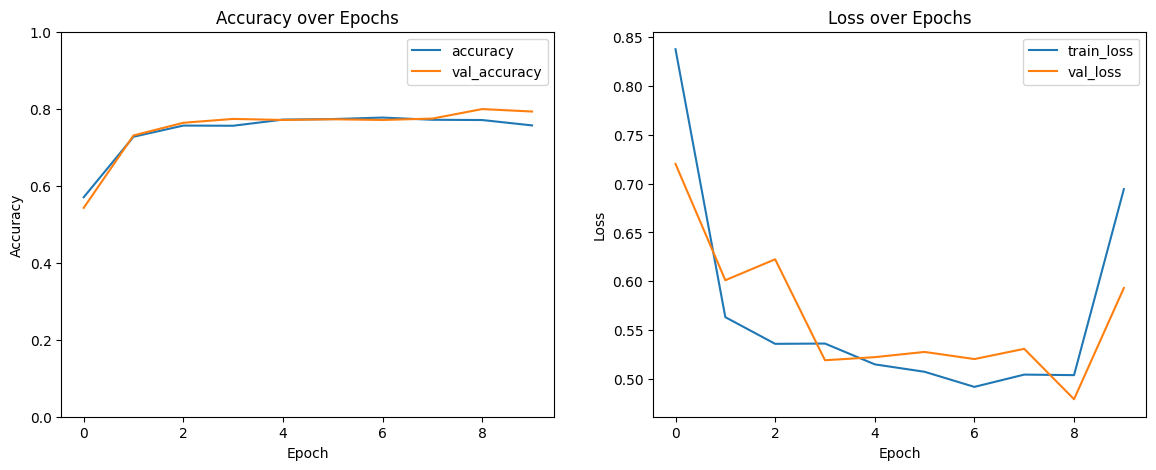

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


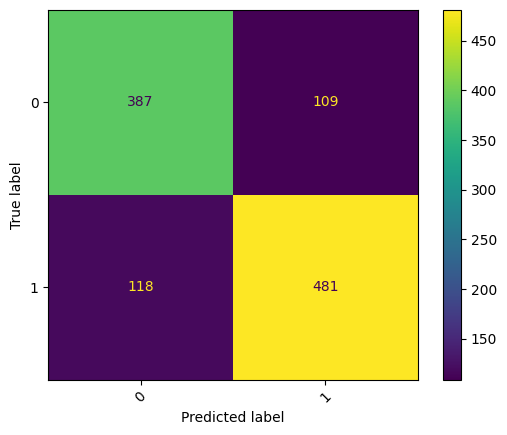

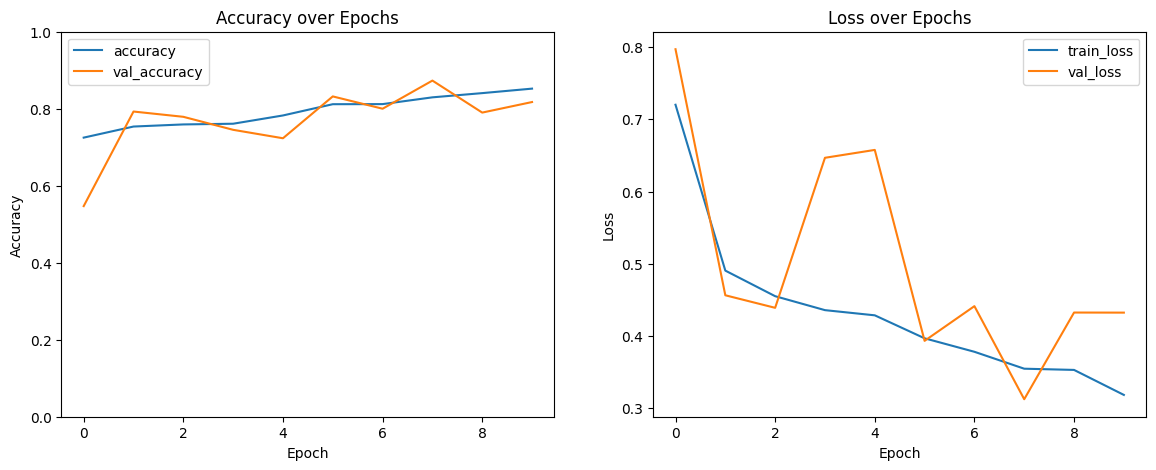

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


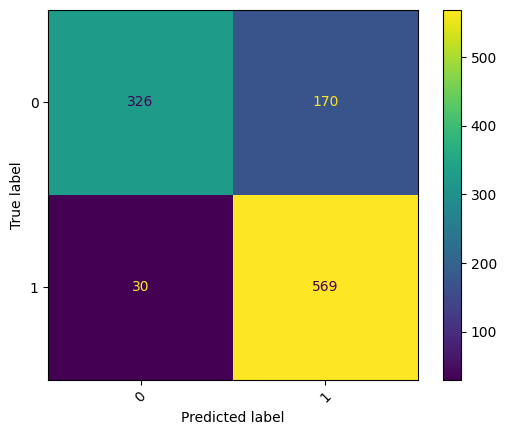

In [25]:
simple_data = {"Learning Rate": [0.0001, 0.0005, 0.001],"Weight Decay": [1e-5, 1e-5, 1e-5],"Validation Accuracy": [0.8319634795188904, 0.7817351818084717, 0.7360730767250061]}
refined_data = {"Learning Rate": [0.0001, 0.001, 0.0005],"Weight Decay": [1e-5, 1e-5, 1e-5],"Validation Accuracy": [0.8328767418861389, 0.7990867495536804, 0.7990867495536804]}
df_simple = pd.DataFrame(simple_data)
df_refined = pd.DataFrame(refined_data)

print("Final Results: Simple CNN")
print(df_simple, "\n")

print("Final Results: Refined CNN")
print(df_refined)

validate_images, validate_labels = [], []
for img, lbl in dataset_binary_validate.unbatch().batch(100):
    validate_images.append(img.numpy())
    validate_labels.append(lbl.numpy())

X_validate = np.concatenate(validate_images)
y_validate = np.concatenate(validate_labels)

simple_model.display_results(X_validate, y_validate)
refined_model.display_results(X_validate, y_validate)

# Results, Analysis, and Discussion
Our simple cnn gives us a nice baseline understanding of how our models perform. We can see that it grows from an initial 0.68 to 0.78 without overfitting as our validation accuracy remains *relatively* stable alongside it. While not apperant here we should note that the model itself is more prone to getting stuck in local minima than any of our other models. As can be seen in our hyperparameter testing however this is likely an issue of its learning rate since the improved learning rate appears to have allowed the model to escape local minima. Unfortunately the model is not that stable and so overly large learning rates can result in catastrophic failure. 

As expected our refined cnn provides vastly better results on the binary problem than the simple cnn primarily due to relatively well known optimizations for the cnn. By having more layers we give the model more opportunities to capture local features which is likely critical in this dataset as the images contain many distinct features. Further, our use of batch normalization results in our model being much more stable than the simple model and less likely to get stuck which we observed. Our use of the dropout layer did not play a significant role in the model as even removed the refined cnn avoid overfitting however this is primarily due to our low epoch.

What surprised me was the poor results of our refined cnn on multi label data. This was so shocking we went back and implemented a simple cnn to work on multi labeled data in an attempt to get a baseline value and better understanding of our results. Observing the results it is clear that our approach may be fundamentally wrong as neither our baseline model nor our refined model were performing particularly well. It was quite interesting to see that our refinements from the binary refined model, when carried over to the multi label problem, outperformed our baseline.

One thing I have learned was how fundamentally important the right model architecture is for the problem. Our refined models are primarily based on the VGGNet model which is a staple of cnn architecture. This shows in the binary tests but shows poorly in the multi label case. This was the primary reason we did not evaluate the hyperparameters of either model, without the fundamental changes required to make it work there is little point.
## The Future
We will be working to refine our understanding of cnn architectures in order to better approach multi label problems and then moving on to refining hyperparameters. After that we are increadibly interested in persuing the use of RNN models on image classification problems like this one that have a lot of noise and require expert knowledge.
# Conclusion
In conclusion our test show us the importance of architectiral choices in CNN's while reminding us that hyperparameter tuning only matters when the model itself is appropriate. Classic CNN refinement technique apply well even to relatively complex data as some instances of our data were of various zoom magnitudes. We also saw that multi label classification remains a challenging model architecture problem that will require significantly more focus. With this information and a direction to move in, we will be able to make continued progress in using machine learning to free up time for medical professionals.